# MBTI Project - Feature Engineering & Preprocessing (step 4)
<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>This section comes after the <b>Exploratory Data Analysis (EDA)</b> step. In the following lines of code you will find the steps I took in terms of preprocessing the available data. What we want to achieve is actually a clean dataset that our machine learning models can analyze well. A reminder that our final goal is create a machine learning model that determines if we can classify MBTI types taking into consideration the posts made by each person.<p>
</div>

<div class="span5 alert alert-danger">

<h3>Disclaimer</h3>
    <p>The purpose of this notebook is to go over certain aspects of Natural Language Processing. There might be some parts of the notebook that do not have particular use for the future of this project but they are useful for learning purposes so I left them inside. <p>
</div>

<br>

### Table of Contents

- [Summarized goals](#goals)
- [Importing Libraries](#importing)
- [Review of our Dataset](#review)
- [Feature Engineering](#nlp)
    - [NLP](#nlp)
    - [TextStat](#stats)
    - [Final Edits](#edits)
- [CountVectorizer](#count)
- [TF-IDF](#tfidf)
- [Multinomial NB](#mnb)
- [Word Clouds](#cloud)
- [Future Actions](#imbalanced)    

<a id=goals></a>

## Summarized Goals
***

We will focus on **Feature Engineering**

[Maarten Grootendorst](https://towardsdatascience.com/4-tips-for-advanced-feature-engineering-and-preprocessing-ec11575c09ea) says "Arguably, two of the most important steps in developing a machine learning model is feature engineering and preprocessing. Feature engineering consists of the creation of features whereas preprocessing involves cleaning the data."

[Emre Rençberoğlu](https://towardsdatascience.com/@emrerencberoglu) says "Feature engineering efforts mainly have two goals:

- Preparing the proper input dataset, compatible with the machine learning algorithm requirements.
- Improving the performance of machine learning models."

<a id=importing></a>

## Imports
***

In [1]:
# data wrangiling libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.transforms
from matplotlib.patches import Patch
import seaborn as sns

%matplotlib inline
sns.set(rc={'axes.facecolor':'white'})

# natural language processing libraries
import nltk
import nltk.corpus 
import textstat

# other libraries
import os
import re
from tqdm import tqdm, tqdm_pandas
tqdm.pandas(desc="Progress!")
import time

/Users/diego/.pyenv/versions/venv-MBTI/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('../../data/mbti_interim.csv', index_col=0)

<a id=review></a>

<br>


## Reviewing our Dataset
***

In [3]:
df.columns

Index(['type', 'posts', 'I', 'J', 'N', 'T', 'NF', 'NT', 'SP', 'SJ',
       'posts_len', 'posts_separated', 'count_posts', 'avg_num_char_x_post',
       'num_of_links', ':D_count', ';D_count', ':)_count', ';)_count',
       ':(_count', 'xD_count', 'XD_count', 'total_emoticons',
       'avg_emoticons_per_post', 'INFJ_mentions', 'ENTP_mentions',
       'INTP_mentions', 'INTJ_mentions', 'ENTJ_mentions', 'ENFJ_mentions',
       'INFP_mentions', 'ENFP_mentions', 'ISFP_mentions', 'ISTP_mentions',
       'ISFJ_mentions', 'ISTJ_mentions', 'ESTP_mentions', 'ESFP_mentions',
       'ESTJ_mentions', 'ESFJ_mentions', 'total_mentions',
       'avg_mentions_per_post', 'I_count', 'me_count', 'my_count',
       'mine_count', 'myself_count', 'We_count', 'us_count', 'our_count',
       'ourselves_count', 'total_first_person', 'avg_first_person',
       'you_count', 'your_count', 'yours_count', 'yourself_count',
       'yourselves_count', 'total_second_person', 'avg_second_person',
       'he_count', 'him_

<br>

Let's go back a bit and keep the first ten columns for the time being. Those columns are the predictor variable (text) and the target variables (MBTI labels)

In [4]:
df = df.iloc[:,0:10]

In [5]:
df.columns

Index(['type', 'posts', 'I', 'J', 'N', 'T', 'NF', 'NT', 'SP', 'SJ'], dtype='object')

<a id=nlp></a>

<br>


## Feature Engineering - NLP
***

At the moment I am not sure if it is better to treat every posts separetly or to use all the posts as one large corpus. I will start by trying the latter way. I will follow the checklist for KDNuggets:

- Remove all irrelevant characters such as any non alphanumeric characters
- Tokenize your text by separating it into individual words
- Remove words that are not relevant, such as “@” twitter mentions or urls
- Convert all characters to lowercase, in order to treat words such as “hello”, “Hello”, and “HELLO” the same
- Consider combining misspelled or alternately spelled words to a single representation (e.g. “cool”/”kewl”/”cooool”)
- Consider lemmatization (reduce words such as “am”, “are”, and “is” to a common form such as “be”) 

Except the 5th point I will do all of the above and try to use the POS_tags as an additional practical learning

In [6]:
# regex remove hyperlinks
df['text_clean'] = df['posts'].str.replace('http\S+|www.\S+', '', case=False)

In [7]:
# Removing unwanted characters
df['text_clean'] = df['text_clean'].str.replace('[^a-zA-Z]', ' ') 

In [8]:
# Making everything lowercase
df['text_clean'] = df['text_clean'].str.lower() 

In [9]:
# tokenize each post
from nltk.tokenize import word_tokenize

df['text_clean'] = df['text_clean'].apply(lambda x: word_tokenize(x))

In [10]:
# lemmatize each word
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

df['text_clean'] = df['text_clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [11]:
# create parts of speech tags (https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
df['pos_tags'] = df['text_clean'].progress_apply(lambda x: [nltk.pos_tag(word_tokenize((y))) for y in x])

Progress!: 100%|██████████| 8675/8675 [53:19<00:00,  2.71it/s]   


In [12]:
df.head()

,type,posts,I,J,N,T,NF,NT,SP,SJ,text_clean,pos_tags
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0,1,0,0,0,"[and, intj, moment, sportscenter, not, top, te...","[[(and, CC)], [(intj, NN)], [(moment, NN)], [(..."
1,ENTP,'I'm finding the lack of me in these posts ver...,0,0,1,1,0,1,0,0,"[i, m, finding, the, lack, of, me, in, these, ...","[[(i, NN)], [(m, NN)], [(finding, VBG)], [(the..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,0,1,1,0,1,0,0,"[good, one, course, to, which, i, say, i, know...","[[(good, JJ)], [(one, CD)], [(course, NN)], [(..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1,0,1,0,0,"[dear, intp, i, enjoyed, our, conversation, th...","[[(dear, NN)], [(intp, NN)], [(i, NN)], [(enjo..."
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1,0,1,0,0,"[you, re, fired, that, s, another, silly, misc...","[[(you, PRP)], [(re, NN)], [(fired, VBN)], [(t..."


In [14]:
df.to_csv('../../data/mbti_nlp.csv')

<a id=stats></a>

<br>


## Feature Engineering - TextStat
***

In this section I will create new features using the library TextStat https://pypi.org/project/textstat/ which offers many possibilities

<br>

**Syllabel Count** Returns the number of syllables present in the given text.

In [13]:
df['syllabel_count'] = df['posts'].progress_apply(lambda x: textstat.syllable_count(x))

Progress!: 100%|██████████| 8675/8675 [01:12<00:00, 120.29it/s]


<br>

**Lexicon Count** Calculates the number of words present in the text. Optional removepunct specifies whether we need to take punctuation symbols into account while counting lexicons.transform

In [14]:
df['lexicon_count'] = df['posts'].progress_apply(lambda x: textstat.lexicon_count(x, removepunct=True))

Progress!: 100%|██████████| 8675/8675 [00:10<00:00, 849.74it/s]


<br>

**Sentence Count** Returns the number of sentences present in the given text.

In [15]:
df['sentence_count'] = df['posts'].progress_apply(lambda x: textstat.sentence_count(x))

Progress!: 100%|██████████| 8675/8675 [00:14<00:00, 608.29it/s]


<br>

**Flesch Reading** Returns the Flesch Reading Ease Score.

| Score | Difficulty |
| --- | --- | 
| 90-100 | Very Easy |
| 80-89 | Easy |
| 70-79 | Fairly Easy |
| 60-69 | Standard |
| 50-59 | Fairly Difficult |
| 30-49 | Difficult |
| 0-29 | Very Confusing |

In [16]:
df['flesch_reading'] = df['posts'].progress_apply(lambda x: textstat.flesch_reading_ease(x))

Progress!: 100%|██████████| 8675/8675 [01:10<00:00, 122.86it/s]


<br>

**The Flesch-Kincaid Grade Level** Returns the Flesch-Kincaid Grade of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [17]:
df['Flesch_Kincaid_Grade_Level'] = df['posts'].progress_apply(lambda x: textstat.flesch_kincaid_grade(x))

Progress!: 100%|██████████| 8675/8675 [01:11<00:00, 120.49it/s]


<br>

**The Fog Scale (Gunning FOG Formula)** Returns the FOG index of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [18]:
df['Fog_Scale'] = df['posts'].progress_apply(lambda x: textstat.gunning_fog(x))

Progress!: 100%|██████████| 8675/8675 [01:11<00:00, 120.93it/s]


<br>

**Automated Readability Index** Returns the ARI (Automated Readability Index) which outputs a number that approximates the grade level needed to comprehend the text. For example if the ARI is 6.5, then the grade level to comprehend the text is 6th to 7th grade.

In [19]:
df['Automated_Readability'] = df['posts'].progress_apply(lambda x: textstat.automated_readability_index(x))

Progress!: 100%|██████████| 8675/8675 [00:26<00:00, 331.30it/s]


<br>

**Coleman-Liau Index** Returns the grade level of the text using the Coleman-Liau Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [20]:
df['Coleman_Liau'] = df['posts'].progress_apply(lambda x: textstat.coleman_liau_index(x))

Progress!: 100%|██████████| 8675/8675 [00:34<00:00, 251.98it/s]


<br>

**Linsear Write Formula** Returns the grade level using the Linsear Write Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [21]:
df['Linsear_Write_Formula'] = df['posts'].progress_apply(lambda x: textstat.linsear_write_formula(x))

Progress!: 100%|██████████| 8675/8675 [00:07<00:00, 1087.30it/s]


<br>

**Linsear Write Formula** Returns the grade level using the Linsear Write Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [22]:
df['Linsear_Write_Formula'] = df['posts'].progress_apply(lambda x: textstat.linsear_write_formula(x))

Progress!: 100%|██████████| 8675/8675 [00:08<00:00, 1032.51it/s]


<br>

**Dale-Chall Readability Score** Different from other tests, since it uses a lookup table of the most commonly used 3000 English words. Thus it returns the grade level using the New Dale-Chall Formula.

| Score | Understood by |
| --- | --- | 
| 4.9 or lower | average 4th-grade student or lower |
| 5.0–5.9 | average 5th or 6th-grade student |
| 6.0–6.9 | average 7th or 8th-grade student |
| 7.0–7.9 | average 9th or 10th-grade student |
| 8.0–8.9 | average 11th or 12th-grade student |
| 9.0–9.9 | average 13th to 15th-grade (college) student |


In [23]:
df['Dale_Chall_Readability_Score'] = df['posts'].progress_apply(lambda x: textstat.dale_chall_readability_score(x))

Progress!: 100%|██████████| 8675/8675 [01:08<00:00, 126.47it/s]


<br>

**Readability Consensus based upon all the above tests** Based upon all the above tests, returns the estimated school grade level required to understand the text.

In [24]:
df['readability_consensus'] = df['posts'].progress_apply(lambda x: textstat.text_standard(x, float_output=False))

Progress!: 100%|██████████| 8675/8675 [04:05<00:00, 35.28it/s]


<a id=edits></a>

<br>


## Feature Engineering - Final Edits
***



I will label the MBTI types as numbers so they are understood by the machine

In [ ]:
# This section of the code converts each mbti type into a number

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
type_labels = df[['type']].apply(lambda x: le.fit_transform(x))
df.insert(1, 'type_label', type_labels)

In [28]:
# I join the text because countvectorizer does not take lists as inputs
df['text_clean_joined'] = df['text_clean'].apply(lambda x: " ".join(x))

In [29]:
# Print the head of the LabelEncoded categorical columns
df.head()

,type,type_label,posts,I,J,N,T,NF,NT,SP,...,sentence_count,flesch_reading,Flesch_Kincaid_Grade_Level,Fog_Scale,Automated_Readability,Coleman_Liau,Linsear_Write_Formula,Dale_Chall_Readability_Score,readability_consensus,text_clean_joined
0,INFJ,8,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0,1,0,0,...,15,25.36,18.9,18.08,31.6,20.43,11.333333,9.00,18th and 19th grade,and intj moment sportscenter not top ten play ...
1,ENTP,3,'I'm finding the lack of me in these posts ver...,0,0,1,1,0,1,0,...,65,70.23,7.9,8.98,11.2,8.99,12.400000,6.53,8th and 9th grade,i m finding the lack of me in these post very ...
2,INTP,11,'Good one _____ https://www.youtube.com/wat...,1,0,1,1,0,1,0,...,30,52.02,12.8,13.18,17.4,11.03,11.600000,7.45,12th and 13th grade,good one course to which i say i know that s m...
3,INTJ,10,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1,0,1,0,...,43,54.86,11.7,12.89,13.8,8.71,13.000000,7.34,11th and 12th grade,dear intp i enjoyed our conversation the other...
4,ENTJ,2,'You're fired.|||That's another silly misconce...,0,1,1,1,0,1,0,...,54,61.77,9.1,10.23,12.5,10.55,6.555556,7.26,10th and 11th grade,you re fired that s another silly misconceptio...


In [30]:
# We save the dataset to avoid having to go through this process again
df.to_csv('../../data/mbti_nlp.csv')

<a id=count></a>

<br>


## CountVectorizer
***

In [2]:
# I add this to avoid having to make the previous calculations again
df = pd.read_csv('../../data/mbti_nlp.csv',index_col=0)

In [3]:
df.head(3)

,type,type_label,posts,I,J,N,T,NF,NT,SP,...,sentence_count,flesch_reading,Flesch_Kincaid_Grade_Level,Fog_Scale,Automated_Readability,Coleman_Liau,Linsear_Write_Formula,Dale_Chall_Readability_Score,readability_consensus,text_clean_joined
0,INFJ,8,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0,1,0,0,...,15,25.36,18.9,18.08,31.6,20.43,11.333333,9.00,18th and 19th grade,and intj moment sportscenter not top ten play ...
1,ENTP,3,'I'm finding the lack of me in these posts ver...,0,0,1,1,0,1,0,...,65,70.23,7.9,8.98,11.2,8.99,12.400000,6.53,8th and 9th grade,i m finding the lack of me in these post very ...
2,INTP,11,'Good one _____ https://www.youtube.com/wat...,1,0,1,1,0,1,0,...,30,52.02,12.8,13.18,17.4,11.03,11.600000,7.45,12th and 13th grade,good one course to which i say i know that s m...


We start by importing the necessary libraries and by updating the stopwords. We need to remember that relevant words are not necessarily the most frequent words since stopwords like “the”, “of” or “a” tend to occur very often in many documents.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

types = [x.lower() for x in df['type'].unique()] # MBTI types are rarely discussed in day to day converstaions, we will take them out since they would have low prediction power
types_plural = [x+'s' for x in types]
additional_stop_words = ['ll','type','fe','ni','na','wa','ve','don','nt','nf', 'ti','se','op','ne'] # some words that appear a lot but do not add value
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words + types + types_plural)

In [5]:
# Specify arguements to limit the number of features generated
cv = CountVectorizer(min_df=0.1, max_df=0.9, stop_words=stop_words)

# Fit, transform, and convert into array
cv_transformed = cv.fit_transform(df['text_clean_joined'])
cv_array = cv_transformed.toarray()

# Print the array shape
print(cv_array.shape)

# Create a DataFrame with these features
cv_df = pd.DataFrame(cv_transformed.toarray(), columns=cv.get_feature_names()).add_prefix('Counts_')

# Add the new columns to the original DataFrame
#speech_df_new = pd.concat([df, cv_df], axis=1, sort=False)
#speech_df_new.head(3) 

(8675, 726)


In [6]:
# let's check the words most used given our parameters
cv_df.sum(axis=0).sort_values(ascending=False)[0:10]

Counts_feel      25728
Counts_make      23659
Counts_say       22726
Counts_friend    22208
Counts_love      21876
Counts_way       21813
Counts_want      21210
Counts_good      20794
Counts_ha        18427
Counts_lot       18200
dtype: int64

In [7]:
# let's bring the mbti types into the table
cv = pd.concat([df['type'], cv_df], axis=1, sort=False)

In [8]:
# we save the dataset for future use in case we want to come back to it
cv.to_csv('../../data/mbti_count_vectorizer.csv')

In [9]:
# since our dataset is skewed towards Notion types and Introvert types we will use relative values instead of absolute values
total_type = cv['type'].value_counts().sort_index()

In [10]:
# we group the CountVectorized dataset and order it alphabetically
cv_grouped = cv.groupby('type').sum().sort_index()

In [11]:
# we divide each column by the amount of observations of each mbti type
cv_grouped = cv_grouped.div(total_type, axis='rows')

In [12]:
cv_grouped.head()

,Counts_ability,Counts_able,Counts_absolutely,Counts_accept,Counts_accurate,Counts_act,Counts_action,Counts_actual,Counts_actually,Counts_add,...,Counts_written,Counts_wrong,Counts_wrote,Counts_xd,Counts_yeah,Counts_year,Counts_yes,Counts_yesterday,Counts_young,Counts_younger
type,,,,,,,,,,,,,,,,,,,,,
ENFJ,0.231579,0.468421,0.321053,0.115789,0.173684,0.384211,0.252632,0.036842,1.489474,0.247368,...,0.121053,0.700000,0.147368,0.515789,0.968421,1.494737,1.747368,0.094737,0.205263,0.152632
ENFP,0.165926,0.437037,0.299259,0.120000,0.130370,0.312593,0.195556,0.106667,1.614815,0.241481,...,0.100741,0.530370,0.142222,0.847407,1.340741,1.512593,1.617778,0.140741,0.201481,0.204444
ENTJ,0.177489,0.497835,0.277056,0.125541,0.199134,0.333333,0.320346,0.129870,1.424242,0.168831,...,0.121212,0.658009,0.181818,0.077922,0.831169,1.437229,1.398268,0.129870,0.164502,0.186147
ENTP,0.183942,0.411679,0.293431,0.140146,0.160584,0.275912,0.220438,0.147445,1.699270,0.233577,...,0.116788,0.635036,0.137226,0.318248,1.186861,1.468613,1.376642,0.086131,0.192701,0.167883
ESFJ,0.190476,0.333333,0.285714,0.166667,0.214286,0.309524,0.214286,0.047619,1.214286,0.285714,...,0.095238,0.452381,0.095238,0.285714,1.000000,2.190476,1.357143,0.095238,0.261905,0.119048


The code below is from this [stackoverflow question](https://stackoverflow.com/a/34298343)

In [13]:
from operator import itemgetter as it
from itertools import repeat
n = 10

top_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=1)[:n])))
                     for _, row in cv_grouped.reset_index().iterrows()])

top_words['type'] = list(total_type.index)
top_words.set_index('type', drop=True, inplace=True)

In [14]:
top_words = top_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [15]:
# most used words from the most used being column 0 to the the 10th most used on column 10
top_words

,0,1,2,3,4,5,6,7,8,9
type,,,,,,,,,,
ENFJ,feel,love,friend,make,say,way,want,good,ha,lot
ENFP,love,feel,friend,make,say,way,want,good,lot,ha
ENTJ,make,say,good,want,feel,ha,way,friend,lot,need
ENTP,make,way,say,friend,good,want,ha,love,lot,feel
ESFJ,feel,love,lot,friend,make,ha,good,want,way,say
ESFP,feel,say,want,make,love,good,friend,lot,ha,guy
ESTJ,say,want,make,friend,love,way,feel,need,lot,good
ESTP,friend,make,good,say,way,want,sure,lot,feel,got
INFJ,feel,love,make,say,way,friend,want,good,ha,life


In [16]:
bottom_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=0)[:n])))
                     for _, row in cv_grouped.reset_index().iterrows()])

bottom_words['type'] = list(total_type.index)
bottom_words.set_index('type', drop=True, inplace=True)
bottom_words = bottom_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [17]:
bottom_words

,0,1,2,3,4,5,6,7,8,9
type,,,,,,,,,,
ENFJ,actual,stick,decide,religion,exist,company,concept,evil,grade,option
ENFP,member,effect,dead,interaction,environment,public,grade,history,longer,present
ENTJ,soul,depressed,hair,helped,middle,humor,shy,color,xd,awkward
ENTP,water,yesterday,support,depressed,helpful,period,sit,ended,wanting,express
ESFJ,cut,intelligent,purpose,decide,effect,intelligence,lie,light,obviously,piece
ESFP,early,death,effort,lose,main,perspective,simply,unhealthy,admit,aspect
ESTJ,ability,considering,extroverted,lose,particularly,quiet,soon,attracted,awkward,baby
ESTP,area,large,particular,smile,belief,exist,lie,note,tendency,approach
INFJ,lazy,debate,stereotype,useful,dead,grade,option,intelligence,actual,effect


In [18]:
sorted_words = sorted(cv.drop('type',axis=1).sum(axis=0))

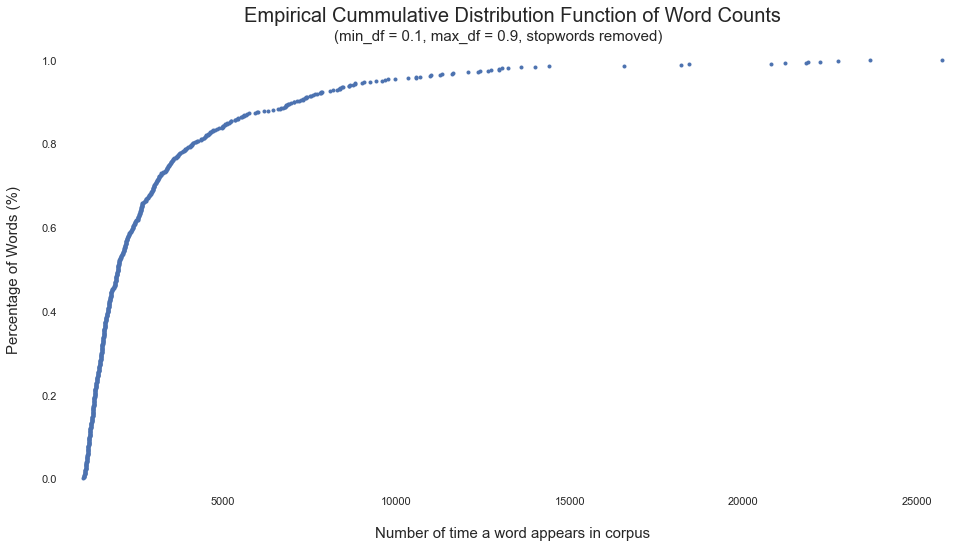

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

x = sorted_words
y = np.arange(1,len(x)+1) / len(x)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x,y, marker='.', linestyle ='none')
#plt.ylim(bottom=0.9, top=1.01)
plt.xlabel('Number of time a word appears in corpus', fontsize=15, labelpad=20)
plt.ylabel('Percentage of Words (%)', fontsize=15, labelpad=20)
plt.title('Empirical Cummulative Distribution Function of Word Counts', pad=30, size=20)
plt.figtext(.5,.90,'(min_df = 0.1, max_df = 0.9, stopwords removed)',fontsize=15,ha='center')
plt.grid(None)
plt.margins(0.02) # Keeps data off plot edges
plt.savefig('img/ECDF_CountVectorizer.png', dpi=200, transparent=True)
plt.show()


<a id=tfidf></a>

## TFIDF

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. In other words, it helps normalize words that appear a lot and are not so relevant to our analysis (like “the”). In other words, with the TFIDFVectorizer the value increases proportionally to count, but is inversely proportional to frequency of the word in the corpus; that is the inverse document frequency (IDF) part.

In [20]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=800, stop_words=stop_words)

# Fit the vectroizer and transform the data
tv_transformed = tv.fit_transform(df['text_clean_joined'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names()).add_prefix('TFIDF_')
tv_df.head(3) 

,TFIDF_ability,TFIDF_able,TFIDF_absolutely,TFIDF_accept,TFIDF_accurate,TFIDF_act,TFIDF_action,TFIDF_actual,TFIDF_actually,TFIDF_add,...,TFIDF_wrote,TFIDF_xd,TFIDF_yeah,TFIDF_year,TFIDF_yep,TFIDF_yes,TFIDF_yesterday,TFIDF_young,TFIDF_younger,TFIDF_youtube
0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.043933,0.108434,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.044538,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.029126,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.143532,0.052040,0.125401,0.0,0.075103,0.0,0.0,0.0,0.068439,0.0,...,0.0,0.0,0.0,0.170160,0.000000,0.071119,0.0,0.0,0.0,0.0


In [21]:
# Isolate the row to be examined
sample_row = tv_df.iloc[0,:]

# Print the top 5 words of the sorted output
print(sample_row.sort_values(ascending=False).head()) 

TFIDF_game     0.278004
TFIDF_video    0.225131
TFIDF_time     0.202861
TFIDF_given    0.175340
TFIDF_left     0.162293
Name: 0, dtype: float64


In [22]:
# let's bring the mbti types into the table
tv = pd.concat([df['type'], tv_df], axis=1, sort=False)

In [23]:
tv.to_csv('../../data/mbti_tfidf.csv')

In [24]:
# we group the TFIDF dataset and order it alphabetically like we did before
tv_grouped = tv.groupby('type').sum().sort_index()

In [25]:
# we divide each column by the amount of observations of each mbti type
tv_grouped = tv_grouped.div(total_type, axis='rows')

In [26]:
# Isolate the row to be examined
sample_row = tv_grouped.iloc[0,:]

# Print the top 5 words of the sorted output
print(sample_row.sort_values(ascending=False).head(10))

TFIDF_like      0.149521
TFIDF_just      0.115845
TFIDF_think     0.113162
TFIDF_people    0.108172
TFIDF_know      0.088128
TFIDF_really    0.085819
TFIDF_feel      0.077050
TFIDF_thing     0.076946
TFIDF_love      0.075650
TFIDF_friend    0.075165
Name: ENFJ, dtype: float64


In [27]:
tv_grouped

,TFIDF_ability,TFIDF_able,TFIDF_absolutely,TFIDF_accept,TFIDF_accurate,TFIDF_act,TFIDF_action,TFIDF_actual,TFIDF_actually,TFIDF_add,...,TFIDF_wrote,TFIDF_xd,TFIDF_yeah,TFIDF_year,TFIDF_yep,TFIDF_yes,TFIDF_yesterday,TFIDF_young,TFIDF_younger,TFIDF_youtube
type,,,,,,,,,,,,,,,,,,,,,
ENFJ,0.011683,0.016348,0.014423,0.006061,0.008602,0.015205,0.011315,0.001955,0.035794,0.011148,...,0.007022,0.023319,0.027639,0.034536,0.008835,0.042451,0.004911,0.009410,0.006815,0.005063
ENFP,0.008225,0.015613,0.012573,0.006092,0.006698,0.012901,0.008998,0.005826,0.037716,0.011037,...,0.007778,0.042401,0.038675,0.035013,0.008869,0.039412,0.007702,0.009797,0.009915,0.009478
ENTJ,0.009882,0.018781,0.012565,0.007092,0.010706,0.015003,0.015989,0.007522,0.034708,0.008319,...,0.009660,0.004790,0.025761,0.035507,0.005972,0.035959,0.008208,0.008065,0.009249,0.005832
ENTP,0.009604,0.015936,0.013148,0.008225,0.009083,0.012159,0.010753,0.008912,0.041828,0.011422,...,0.007258,0.017771,0.037175,0.037035,0.008994,0.036297,0.005149,0.009897,0.008314,0.007710
ESFJ,0.008768,0.011642,0.012123,0.007237,0.010561,0.013737,0.010122,0.002336,0.027288,0.012756,...,0.004252,0.013814,0.029790,0.048795,0.004157,0.032899,0.005526,0.011349,0.004909,0.002224
ESFP,0.005905,0.014364,0.006734,0.004672,0.013990,0.006916,0.008112,0.008396,0.032447,0.012553,...,0.007279,0.007924,0.032910,0.033892,0.011195,0.031072,0.004104,0.006108,0.009235,0.006262
ESTJ,0.000000,0.016496,0.012110,0.011905,0.009783,0.011434,0.012387,0.002852,0.029937,0.008310,...,0.011976,0.027738,0.013040,0.043441,0.007728,0.037194,0.001455,0.006914,0.002651,0.007487
ESTP,0.008049,0.014805,0.008236,0.009251,0.007592,0.012758,0.014233,0.005626,0.031810,0.010157,...,0.006814,0.008117,0.035602,0.031225,0.010571,0.026685,0.007279,0.007577,0.007227,0.005634
INFJ,0.008565,0.020216,0.013921,0.007842,0.008280,0.012103,0.010417,0.005919,0.035658,0.009492,...,0.009195,0.016179,0.027272,0.044678,0.006134,0.039681,0.007827,0.010279,0.010859,0.008101


In [28]:
n = 10

top_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=1)[:n])))
                     for _, row in tv_grouped.reset_index().iterrows()])

top_words['type'] = list(total_type.index)
top_words.set_index('type', drop=True, inplace=True)

In [29]:
top_words = top_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [30]:
# most used words from the most used being column 0 to the the 10th most used on column 10
top_words

,0,1,2,3,4,5,6,7,8,9
type,,,,,,,,,,
ENFJ,like,just,think,people,know,really,feel,thing,love,friend
ENFP,like,just,think,people,know,really,love,thing,time,friend
ENTJ,like,just,think,people,know,thing,time,really,make,want
ENTP,like,just,think,people,know,thing,really,time,make,friend
ESFJ,like,think,people,just,know,thing,really,time,lot,love
ESFP,like,just,think,people,know,really,feel,thing,say,time
ESTJ,like,think,people,just,thing,know,want,time,say,really
ESTP,like,just,think,people,know,really,friend,thing,time,lol
INFJ,like,just,think,people,know,really,thing,time,feel,love


In [31]:
bottom_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=0)[:n])))
                     for _, row in tv_grouped.reset_index().iterrows()])

bottom_words['type'] = list(total_type.index)
bottom_words.set_index('type', drop=True, inplace=True)
bottom_words = bottom_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [32]:
bottom_words

,0,1,2,3,4,5,6,7,8,9
type,,,,,,,,,,
ENFJ,actual,religious,stick,match,decide,religion,sport,average,city,exist
ENFP,gender,philosophy,religious,member,score,definition,effect,average,interaction,sport
ENTJ,kitteh,crush,soul,upset,earth,middle,helped,depressed,hair,shy
ENTP,wonderful,water,upset,sharing,husband,earth,conflict,helpful,insight,yesterday
ESFJ,city,cut,intelligent,purpose,light,intelligence,stick,average,law,religion
ESFP,early,wall,death,fairly,lose,philosophy,main,law,simply,intelligent
ESTJ,ability,considering,extroverted,film,fucking,kitteh,lose,particularly,quiet,soon
ESTP,film,particular,area,large,sharing,lie,note,belief,philosophy,exist
INFJ,lazy,sport,average,stereotype,debate,law,philosophy,fucking,useful,research


<div class="span alert alert-info">
    <h4>Conclusion</h4> 
    
<p>We can see from the CountVectorizer and the TF-IDF that if we use them to determine the words that appear the most we get very similar across MBTI types. While the values themselves of the CV and TF-IDF are useful for machines to understand our data, the words are not offering us interesting insights. We need a better model for this. We might as well also simplify the problem by analysing individual traits (I/E, N/S, T/F, J/P) to make it easier to understand<p> 
</div>

<br>

## Multinomial NB

In [3]:
# We import the dataset again in case we want to start here
df = pd.read_csv('../../data/mbti_nlp.csv',index_col=0)

We start by importing the necessary libraries and by updating the stopwords. We need to remember that relevant words are not necessarily the most frequent words since stopwords like “the”, “of” or “a” tend to occur very often in many documents.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

types = [x.lower() for x in df['type'].unique()] # MBTI types are rarely discussed in day to day converstaions, we will take them out since they would have low prediction power
types_plural = [x+'s' for x in types]
additional_stop_words = ['ll','type','fe','ni','na','wa','ve','don','nt','nf', 'ti','se','op','ne'] # some words that appear a lot but do not add value
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words + types + types_plural)

We will use a Naïve Bayes (NB) classifier to determine the key words for each MBTI attribute. `sklearn` offers several algorithms for NB, namely (from [here](https://michael-fuchs-python.netlify.app/2019/12/15/introduction-to-naive-bayes-classifier/)):

- Gaussian NB: When the predictors take up a continuous value and are not discrete.
- Bernoulli NB: This is similar to the multinomial naive bayes but the predictors are boolean variables.
- Multinomial NB: The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.  

For our task we will use Multinomial NB with crossvalidation

<div class="span5 alert alert-danger">
    <b>Note:</b> The sklearn documentation says: "On the flip side, although naive Bayes is known as a decent classifier, it is known to be a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously." . <a href='https://stats.stackexchange.com/a/399732'> This stack exchange</a> answer says: "it assumes the features are independent, the probabilities are incorrect if this assumption is not correct."
</div>

In [35]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [36]:
# we create a function that applies countvectorizer to our data and separates it between our predictors and our target variable
def make_xy(dataframe, text_column, target, vectorizer=None):
    """Creates the X and y arrays, the X as a CountVectorized numpy array and the y as a binomial array"""    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=0.1,max_df=0.9, stop_words=stop_words)
    X = vectorizer.fit_transform(dataframe[text_column])
    X = X.tocsc() 
    y = dataframe[target]
    return X, y

def cv_score(clf, X, y, scorefunc):
    """This is the crossvalidation function"""
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X):                               # split data into train/test groups, 5 times
        clf.fit(X[train], y.reset_index(drop=True).T[train])                # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y.reset_index(drop=True).T[test]) # evaluate score function on held-out data
    return result / nfold                                                   # average

def log_likelihood(clf, x, y):                                               
    """This is the scorefunc we will use in the function above"""
    prob = clf.predict_log_proba(x)
    zero = y == 0
    one = ~zero
    return prob[zero, 0].sum() + prob[one, 1].sum()

In [37]:
def compute_MNB(target_column):
    """This function computes the results of the previous functions and returns the best parameters"""

    X, y = make_xy(df, 'text_clean_joined', target_column)

    # let's check how many of each class we have to understand how imbalanced our dataset is
    np.unique(y, return_counts=True)

    # now let's separate the data into the train and test datasets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # separates data by index 
    i_train, i_test = train_test_split(range(df.shape[0]), test_size=0.3, random_state=42) 
    mask = np.zeros(df.shape[0], dtype=np.bool)
    mask[i_test] = True

    #the grid of parameters to search over
    alphas = [0.1, 1, 5, 10, 50]
    min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    best_min_df = None
    maxscore=-np.inf

    for alpha in alphas:
        for min_df in tqdm(min_dfs):         
            vectorizer = CountVectorizer(min_df = min_df, max_df=0.9, stop_words=stop_words)       
            Xthis, ythis = make_xy(df, 'text_clean_joined', target_column, vectorizer)
            Xtrainthis=Xthis[mask]
            ytrainthis=ythis[mask]

            #your code here
            clf = MultinomialNB(alpha=alpha)
            cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

            if cvscore > maxscore:
                maxscore = cvscore
                best_alpha, best_min_df = alpha, min_df

    # will return the best parameters
    print("alpha: %f" % best_alpha)
    print("min_df: %f" % best_min_df)

In [38]:
def best_MNB(chosen_alpha, chosen_min_df):
    """From the previous function we got the best parameters, we can use them to create our optimal model
    returns model and vectorizer"""
    vectorizer = CountVectorizer(min_df = chosen_min_df, max_df=0.9, stop_words=stop_words)
    X, y = make_xy(df, 'text_clean_joined', target_column, vectorizer)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = MultinomialNB(alpha=chosen_alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print('Classification Report')
    print(classification_report(y_test, y_pred))
    print('-'*20)
    print('Confussion Matrix')
    print(confusion_matrix(y_test,y_pred))
    print('-'*20)
    print('Accuracy Score (y_train, predict(X_train) & y_test, y_pred)')
    print(accuracy_score(y_train,clf.predict(X_train)))
    print(accuracy_score(y_test,y_pred))
    
    return clf, vectorizer, X_test

In [39]:
def word_prob(n, model, vect, x_test):
    """the following lines provide the n best predictive words for the specified types"""
    top_n_words = n
    bottom_n_words = n

    words = np.array(vect.get_feature_names())

    x = np.eye(x_test.shape[1])
    probs = model.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:top_n_words]]
    bad_words = words[ind[-bottom_n_words:]]

    good_prob = probs[ind[:top_n_words]]
    bad_prob = probs[ind[-bottom_n_words:]]

    #print("Target\t     P(column | word)")
    #for w, p in zip(good_words, good_prob):
     #   print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

    #print("Opposite\t     P(column | word)")
    #for w, p in zip(bad_words, bad_prob):
     #   print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
        
    return pd.DataFrame({target_column +'_words': good_words, target_column +'_probability': [round(1 - np.exp(p),2) for p in good_prob], 
                         opposite_column +'_words': bad_words[::-1], opposite_column +'_probability': [round(1 - np.exp(p),2) for p in bad_prob][::-1]})

### Introversion vs. Extraversion

In [40]:
target_column = 'I'
opposite_column = 'E'

In [41]:
compute_MNB(target_column)

100%|██████████| 5/5 [00:41<00:00,  8.31s/it]

alpha: 10.000000
min_df: 0.100000


In [42]:
clf, vectorizer, X_test = best_MNB(chosen_alpha=10, chosen_min_df=0.1)

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.50      0.44       572
           1       0.85      0.78      0.81      2031

    accuracy                           0.72      2603
   macro avg       0.62      0.64      0.63      2603
weighted avg       0.75      0.72      0.73      2603

--------------------
Confussion Matrix
[[ 286  286]
 [ 447 1584]]
--------------------
Accuracy Score (y_train, predict(X_train) & y_test, y_pred)
0.7320487483530962
0.7184018440261237


In [43]:
results = word_prob(n=50, model=clf, vect=vectorizer, x_test=X_test)

# let's check how the results look like
results.head()

,I_words,I_probability,E_words,E_probability
0,dream,0.84,debate,0.66
1,death,0.84,bored,0.66
2,listening,0.83,xd,0.68
3,quiet,0.83,super,0.68
4,water,0.83,lol,0.69


### Intuition vs. Sensing

In [44]:
target_column = 'N'
opposite_column = 'S'

In [45]:
compute_MNB(target_column)

100%|██████████| 5/5 [00:38<00:00,  7.70s/it]

alpha: 10.000000
min_df: 0.100000


In [46]:
clf, vectorizer, X_test = best_MNB(chosen_alpha=10, chosen_min_df=0.1)

Classification Report
              precision    recall  f1-score   support

           0       0.30      0.38      0.34       377
           1       0.89      0.85      0.87      2226

    accuracy                           0.78      2603
   macro avg       0.60      0.62      0.60      2603
weighted avg       0.81      0.78      0.79      2603

--------------------
Confussion Matrix
[[ 145  232]
 [ 332 1894]]
--------------------
Accuracy Score (y_train, predict(X_train) & y_test, y_pred)
0.8055006587615283
0.7833269304648482


In [47]:
new_results = word_prob(n=50, model=clf, vect=vectorizer, x_test=X_test)

# we append the new results to our previous dataframe
results = pd.concat([results,new_results], axis=1)

### Thinking vs. Feeling

In [48]:
target_column = 'T'
opposite_column = 'F'

In [49]:
compute_MNB(target_column)

100%|██████████| 5/5 [00:37<00:00,  7.44s/it]

alpha: 50.000000
min_df: 0.100000


In [50]:
clf, vectorizer, X_test = best_MNB(chosen_alpha=50, chosen_min_df=0.1)

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1416
           1       0.72      0.71      0.71      1187

    accuracy                           0.74      2603
   macro avg       0.74      0.74      0.74      2603
weighted avg       0.74      0.74      0.74      2603

--------------------
Confussion Matrix
[[1085  331]
 [ 345  842]]
--------------------
Accuracy Score (y_train, predict(X_train) & y_test, y_pred)
0.7676218708827405
0.7402996542451018


In [51]:
new_results = word_prob(n=50, model=clf, vect=vectorizer, x_test=X_test)
results = pd.concat([results,new_results], axis=1)

### Judging vs. Perceiving

In [52]:
target_column = 'J'
opposite_column = 'P'

In [53]:
compute_MNB(target_column)

100%|██████████| 5/5 [00:36<00:00,  7.38s/it]

alpha: 50.000000
min_df: 0.100000


In [54]:
clf, vectorizer, X_test = best_MNB(chosen_alpha=50, chosen_min_df=0.1)

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      1586
           1       0.50      0.51      0.51      1017

    accuracy                           0.61      2603
   macro avg       0.59      0.59      0.59      2603
weighted avg       0.61      0.61      0.61      2603

--------------------
Confussion Matrix
[[1061  525]
 [ 496  521]]
--------------------
Accuracy Score (y_train, predict(X_train) & y_test, y_pred)
0.6525032938076416
0.6077602766039185


In [55]:
new_results = word_prob(n=50, model=clf, vect=vectorizer, x_test=X_test) 
results = pd.concat([results,new_results], axis=1)

In [56]:
# let's check the final results
results.head(15)

,I_words,I_probability,E_words,E_probability,N_words,N_probability,S_words,S_probability,T_words,T_probability,F_words,F_probability,J_words,J_probability,P_words,P_probability
0,dream,0.84,debate,0.66,human,0.92,car,0.78,argument,0.64,beautiful,0.27,intuition,0.51,fuck,0.29
1,death,0.84,bored,0.66,soul,0.92,si,0.79,debate,0.64,hi,0.31,plan,0.49,lazy,0.31
2,listening,0.83,xd,0.68,belief,0.92,dominant,0.80,knowledge,0.63,xd,0.32,dear,0.49,shit,0.32
3,quiet,0.83,super,0.68,society,0.91,stereotype,0.81,intelligence,0.63,heart,0.32,dominant,0.48,creative,0.33
4,water,0.83,lol,0.69,concept,0.91,pay,0.81,shit,0.62,song,0.32,welcome,0.47,song,0.33
5,computer,0.83,fun,0.69,intelligence,0.91,tv,0.82,research,0.61,shy,0.33,goal,0.47,awesome,0.33
6,human,0.82,awesome,0.69,dark,0.91,dont,0.82,fuck,0.61,loved,0.33,rare,0.47,damn,0.34
7,beautiful,0.82,fuck,0.69,debate,0.91,computer,0.82,computer,0.60,dream,0.33,behavior,0.47,suck,0.34
8,music,0.82,haha,0.69,religion,0.91,buy,0.82,science,0.60,sensitive,0.34,friendship,0.47,bored,0.34
9,religion,0.82,crazy,0.70,brain,0.90,introvert,0.82,rule,0.60,love,0.34,user,0.47,dont,0.34


<div class="span alert alert-info">
    <h4>Conclusion</h4> 
    
<p>We can see that using our Multinomial NB models and focusing only on the individual traits actually gives us words that one might expect from each attribute. Some of the most surprising one for each letter I would say are:
    <ul>
        <li>Introversion: quiet</li>
        <li>Extraversion: extrovert</li>
        <li>Intuition: soul</li>
        <li>Sensing: buy</li>
        <li>Thinking: knowledge</li>
        <li>Feeling: love</li>
        <li>Judging: plan</li>
        <li>Perceiving: creative</li>
    </ul>
<p> 
</div>

<a id=cloud></a>

## Word Cloud

Let's try to give a simple image for the results. We will use a word cloud on both the results from the CountVectorizer and from the Multinomial NB. 

In [57]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [58]:
# we save the words without the prefix "count"
words = [x.split('_')[1] for x in list(cv.columns[1:])]

# we group the words by MBTI type
word_cloud = cv.groupby('type').sum()

# substitute the column names
word_cloud.columns = words

In [59]:
word_cloud_dict = list(zip(sorted(types), [word_cloud.iloc[x,:].to_dict() for x in range(16)]))

In [60]:
#Does not work yet, the pixels are very bad

#ENFJ = word_cloud.iloc[0,:].to_dict()
#mask = np.array(Image.open('img/ENFJ.jpg'))

#wordcloud = WordCloud(background_color='white',max_words=1000, max_font_size=200, random_state=42, mask=mask, width=800, height=1600)
#wordcloud.generate_from_frequencies(frequencies=ENFJ)

#plt.figure(figsize=(16,10))
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.tight_layout(pad=0)
#plt.show()



ENFJ Word Cloud


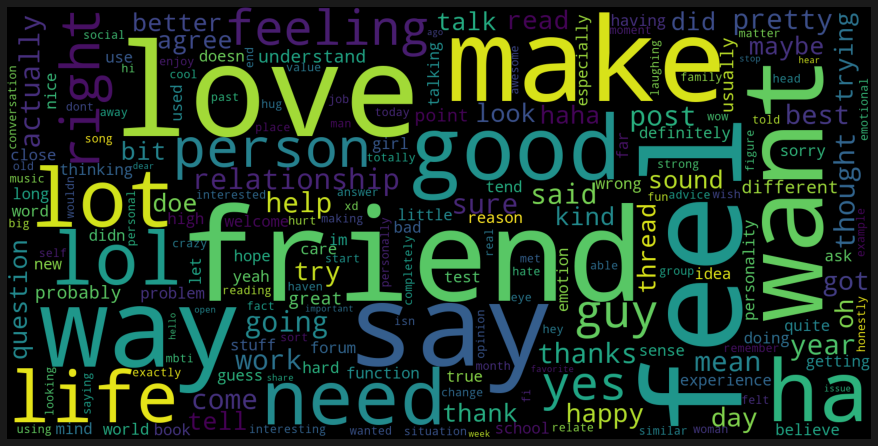



ENFP Word Cloud


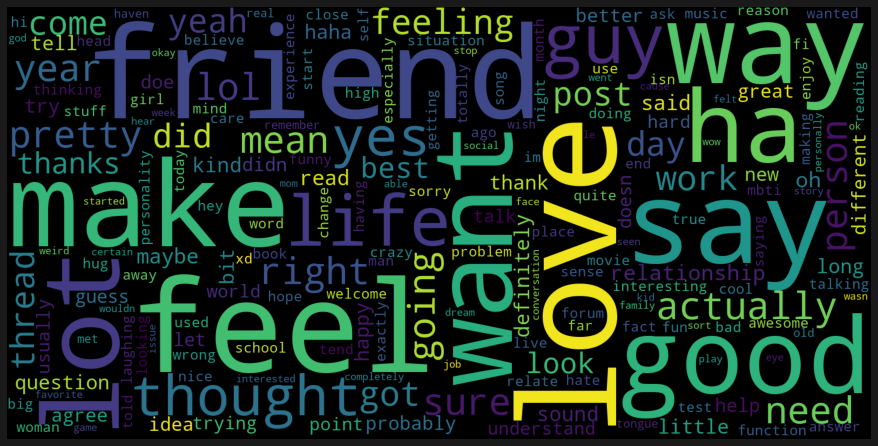



ENTJ Word Cloud


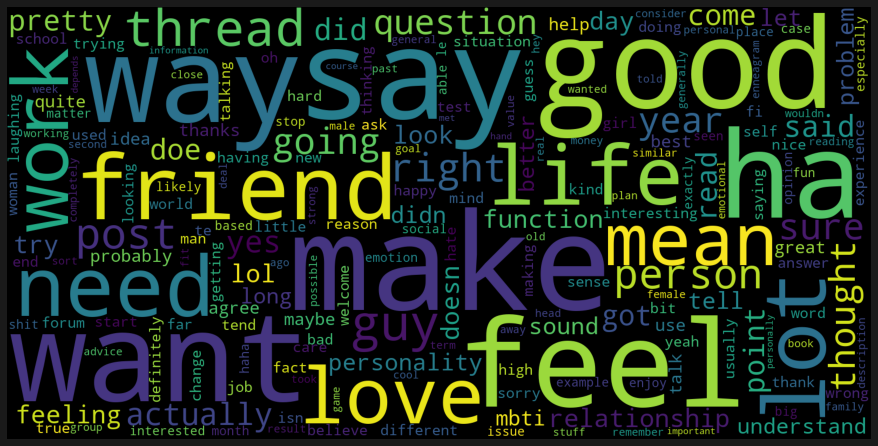

In [61]:
for mbti, dictionary in word_cloud_dict[0:3]:
    wordcloud = WordCloud(max_font_size=250, width=1600, height=800).generate_from_frequencies(dictionary)
    
    print()
    print()
    print(mbti.upper() + ' Word Cloud')
    plt.figure( figsize=(12,8), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig('img/'+mbti.upper()+'_Word_Cloud.png', dpi=100)
    plt.show()

As we can see, these word clouds do not offer much insights. Now we will do a wordcloud taking into account not the frequency itself but the probabilities we calculated for the MultinomialNB before. This is what will determine the size of the words.

In [65]:
columns_list = list(results.columns)
columns_list = [(columns_list[x], columns_list[x+1]) for x in range(0,len(columns_list),2)]

In [84]:
columns_list

[('I_words', 'I_probability'),
 ('E_words', 'E_probability'),
 ('N_words', 'N_probability'),
 ('S_words', 'S_probability'),
 ('T_words', 'T_probability'),
 ('F_words', 'F_probability'),
 ('J_words', 'J_probability'),
 ('P_words', 'P_probability')]

I_words



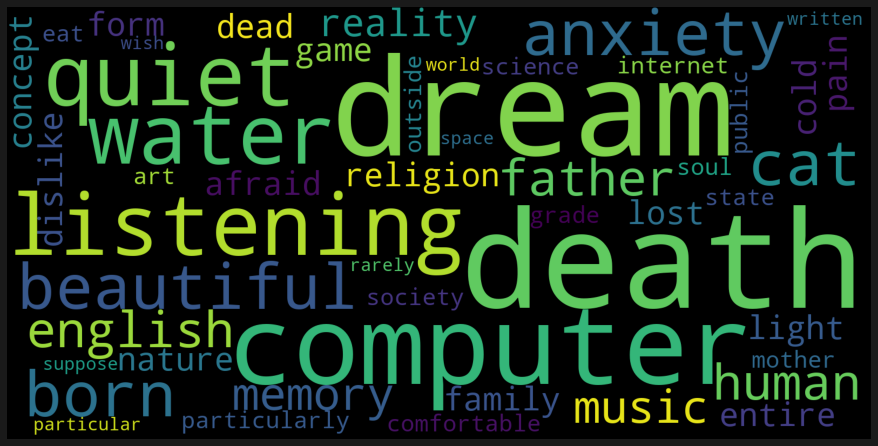




E_words



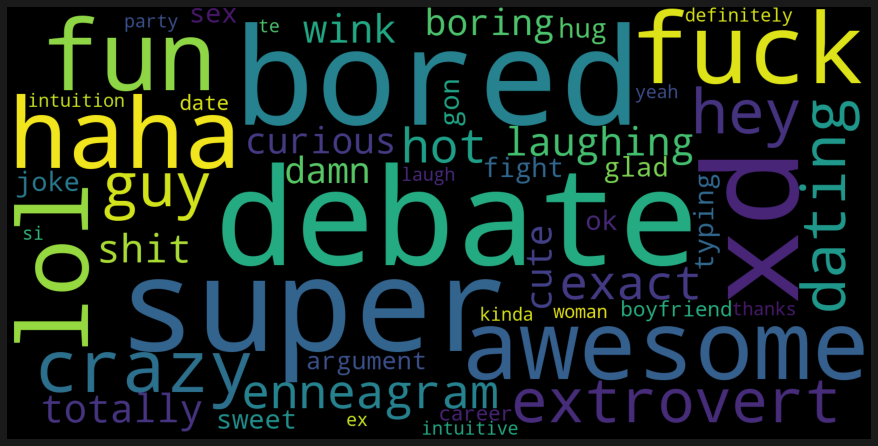




N_words



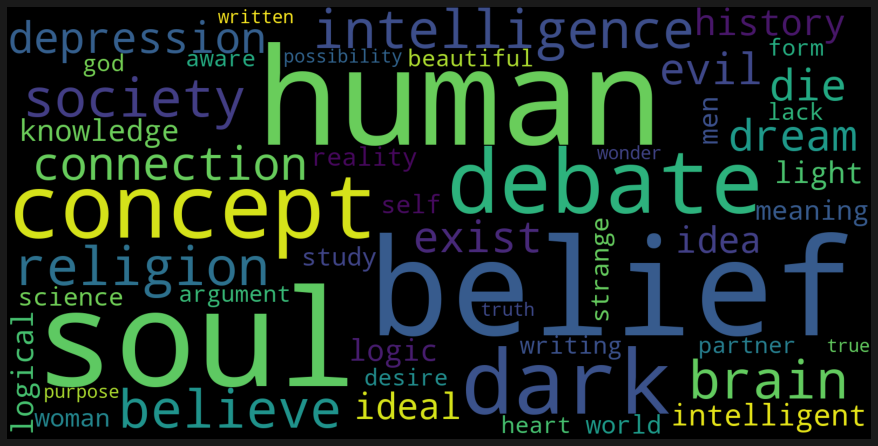




S_words



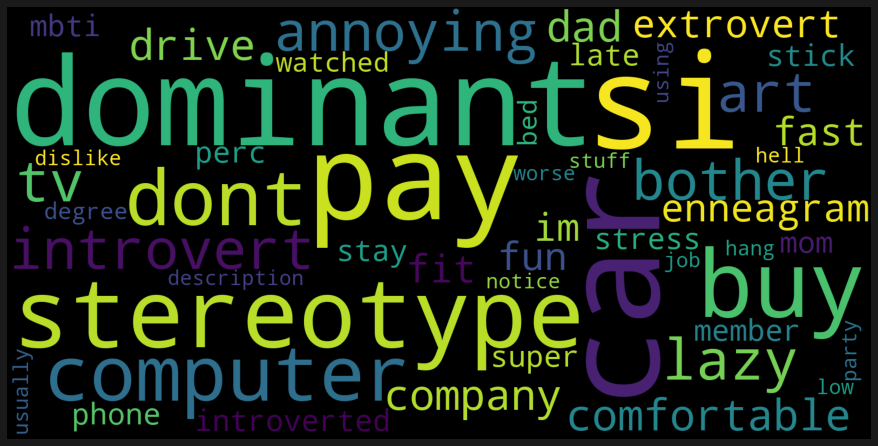




T_words



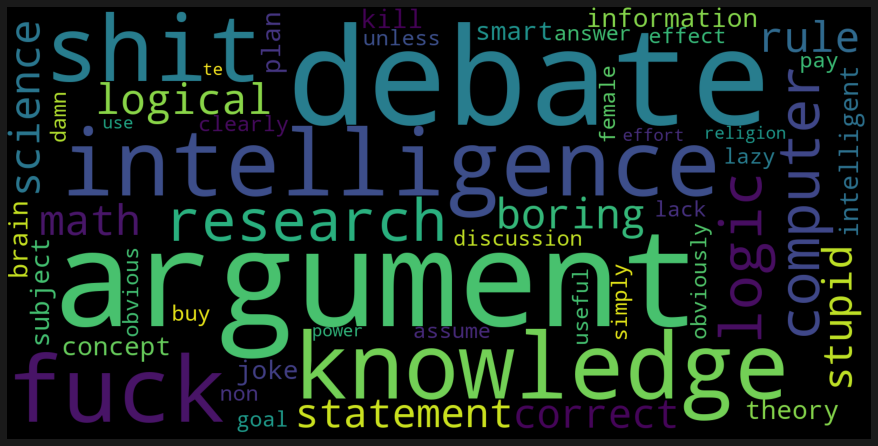




F_words



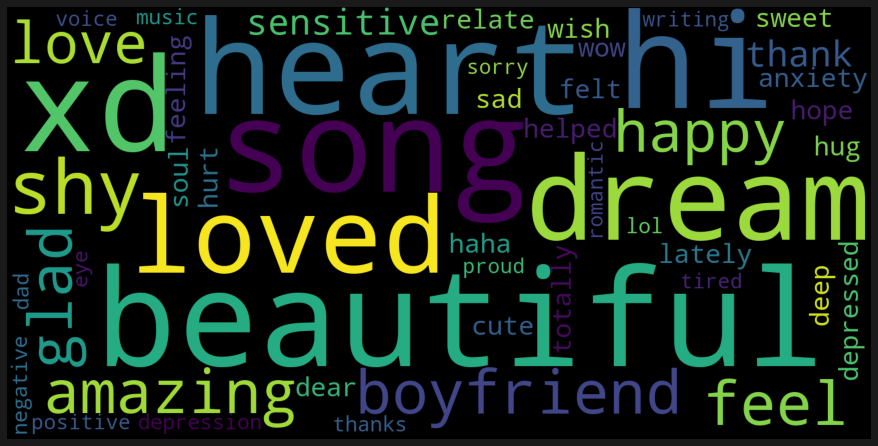




J_words



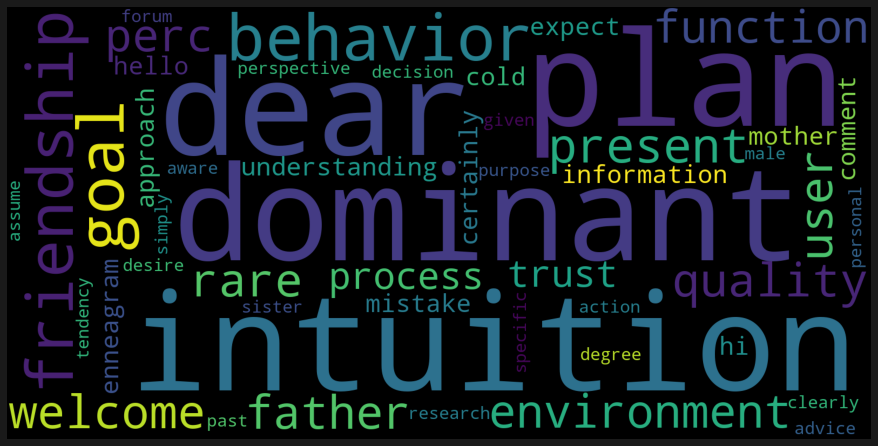




P_words



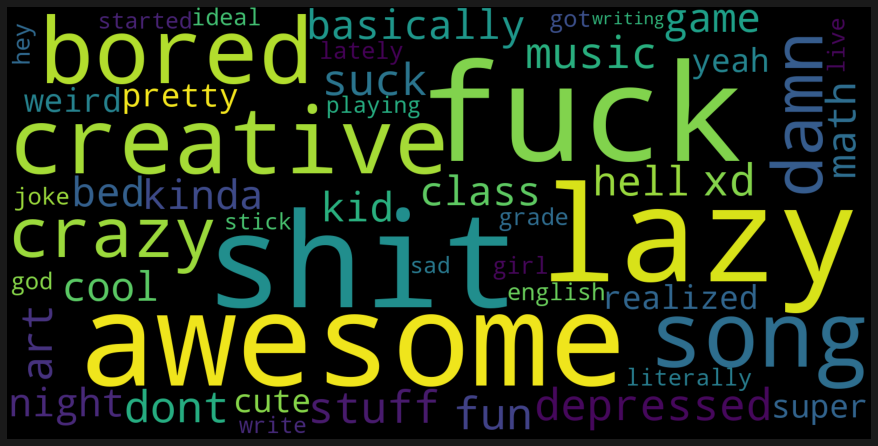

In [85]:
for words, probs in columns_list:
    
    if words in ['E_words','S_words','F_words','P_words']:
        mydict_int = dict([k, float(v[0])] for k, v in results.groupby(words)[probs].apply(lambda x: (1-x).tolist()).to_dict().items())
        wordcloud = WordCloud(max_font_size=250, width=1600, height=800).generate_from_frequencies(mydict_int)
    
    else:
        mydict_int = dict([k, float(v[0])] for k, v in results.groupby(words)[probs].apply(lambda x: x.tolist()).to_dict().items())
        wordcloud = WordCloud(max_font_size=250, width=1600, height=800).generate_from_frequencies(mydict_int)

    print(words)
    print()
    plt.figure( figsize=(12,8), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig('img/'+words+'_word_cloud.png', dpi=100)
    plt.show()
    print()
    print()
    print()

In [87]:
results.to_csv('../../data/mbti_word_probabilities.csv')

<a id=imbalanced></a>

## Future ideas:

### Subtokenization

I saw this on the website "paperspace":

"Recent works have been done on tokenization, leveraging "subtoken" tokenization. Subtokens extends the previous splitting strategy to furthermore explode a word into grammatically logicial sub-components learned from the data.

Taking our previous example of the words cat and cats, a sub-tokenization of the word cats would be [cat, ##s]. Where the prefix "##" indicates a subtoken of the initial input. Such training algorithms might extract sub-tokens such as "##ing", "##ed" over English corpus.

As you might think of, this kind of sub-tokens construction leveraging compositions of "pieces" overall reduces the size of the vocabulary you have to carry to train a Machine Learning model. On the other side, as one token might be exploded into multiple subtokens, the input of your model might increase and become an issue on model with non-linear complexity over the input sequence's length."

![subtokenization](https://nlp.fast.ai/images/multifit_vocabularies.png)
 
Among all the tokenization algorithms, we can highlight a few subtokens algorithms used in Transformers-based SoTA models : 

- [Byte Pair Encoding (BPE) - Neural Machine Translation of Rare Words with Subword Units (Sennrich et al., 2015)](https://arxiv.org/abs/1508.07909)
- [Word Piece - Japanese and Korean voice search (Schuster, M., and Nakajima, K., 2015)](https://research.google/pubs/pub37842/)
- [Unigram Language Model - Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, T., 2018)](https://arxiv.org/abs/1804.10959)
- [Sentence Piece - A simple and language independent subword tokenizer and detokenizer for Neural Text Processing (Taku Kudo and John Richardson, 2018)](https://arxiv.org/abs/1808.06226)

Going through all of them is out of the scope of this notebook, so we will just highlight how you can use them.

### @huggingface/tokenizers library 
Along with the transformers library, we @huggingface provide a blazing fast tokenization library
able to train, tokenize and decode dozens of Gb/s of text on a common multi-core machine.

The library is written in Rust allowing us to take full advantage of multi-core parallel computations in a native and memory-aware way, on-top of which 
we provide bindings for Python and NodeJS (more bindings may be added in the future). 

We designed the library so that it provides all the required blocks to create end-to-end tokenizers in an interchangeable way. In that sense, we provide
these various components: 

- **Normalizer**: Executes all the initial transformations over the initial input string. For example when you need to
lowercase some text, maybe strip it, or even apply one of the common unicode normalization process, you will add a Normalizer. 
- **PreTokenizer**: In charge of splitting the initial input string. That's the component that decides where and how to
pre-segment the origin string. The simplest example would be like we saw before, to simply split on spaces.
- **Model**: Handles all the sub-token discovery and generation, this part is trainable and really dependant
 of your input data.
- **Post-Processor**: Provides advanced construction features to be compatible with some of the Transformers-based SoTA
models. For instance, for BERT it would wrap the tokenized sentence around [CLS] and [SEP] tokens.
- **Decoder**: In charge of mapping back a tokenized input to the original string. The decoder is usually chosen according
to the `PreTokenizer` we used previously.
- **Trainer**: Provides training capabilities to each model.

For each of the components above we provide multiple implementations:

- **Normalizer**: Lowercase, Unicode (NFD, NFKD, NFC, NFKC), Bert, Strip, ...
- **PreTokenizer**: ByteLevel, WhitespaceSplit, CharDelimiterSplit, Metaspace, ...
- **Model**: WordLevel, BPE, WordPiece
- **Post-Processor**: BertProcessor, ...
- **Decoder**: WordLevel, BPE, WordPiece, ...

All of these building blocks can be combined to create working tokenization pipelines. 

### Dealing with Imbalanced Text Data

**Pending**

[article](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8)

In [65]:
df.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [66]:
## Function to find synonym of words 
import spacy
import en_core_web_sm # python -m spacy download en_core_web_sm 
from py_thesaurus import Thesaurus
import nltk 
from nltk.corpus import wordnet 
import random

nlp = en_core_web_sm.load()